## Analysis of the method with simulations, with the Universitat Jaume data and with the Sensation dataset

 


### Simulation

In [1]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

plt.rcParams.update({'font.size': 16})

In [99]:
#initializations
import numpy as np
import os
import math
init_timestamp = 1436047260000 
#beta = (60/55)*60*1000 # in ms, according to the paper Freudiger 2015, mean time delay between packets
lambd =  math.log(2)/33 # packet rate per second ; the median interarrival time from data is 33 sec
beta = (1/lambd) * 1000 # mean time delay between packets
sigma_est = 3 # the average gaussian error of the optimization by multilateration
half_dist_teleport =10 # half of the distance between two twin points
sigma_teleport = 3 # the average displacement of the twin from the firstly generated position
measurement_delay = 1000 # in ms , delay between two measurements in the original positions
randomized_probability = 0.15 # the probability that a mac address is randomized
path_simdata = "/home/ubuntu/Arena_sim_data/"

In [3]:
# for all persons generates (simulates) the first moment they were detected
def generate_first_moment_visible(crowd_size): #initialization      
    next_moment =[]
    for i in range(0, crowd_size):
        delay = np.random.exponential(beta)
        next_moment.append(int(init_timestamp  + delay))    
    return next_moment    

In [4]:
#test
next_moment = generate_first_moment_visible(3)
next_moment

[1436047293267, 1436047286166, 1436047261876]

In [5]:
# given a timestamp, generates the next moment for a particular device to be detected
def gen_next_moment(timestamp_now): # next moment is drawn from exponential(1/beta) distribution
    delay = np.random.exponential(beta)+1# avoid 0
    return int(timestamp_now + delay)

In [6]:
#test
next_mom = gen_next_moment(3)

In [7]:
# makes a new record in the format of the json file that is output of Arena multilateration and input to the density estimation method
def make_new_record(record, new_position, randomized):#record = [timestamp, personId, x, y], new_position = [x,y]
    sigma_x =  np.random.exponential(sigma_est)
    sigma_y =  np.random.exponential(sigma_est)
    new_record = {}
    new_record["measurementTimestamp"] = record[0]
    new_record["value"] = {}
    new_record["value"]["sourceMac"] = record[1]
    new_record["value"]["averagecoordinate"] = {}
    new_record["value"]["averagecoordinate"]["avg"] = {}
    new_record["value"]["averagecoordinate"]["avg"]["coordinates"] =[new_position[0], new_position[1], 0.0]
    new_record["value"]["averagecoordinate"]["error"] = {}
    new_record["value"]["averagecoordinate"]["error"]["coordinates"] = [sigma_x, sigma_y, 1000.0]#in the real data for z is 1000
    new_record["value"]["trackeeHistory"]={}
    new_record["value"]["trackeeHistory"]["localMac"] = randomized
    return new_record

In [8]:
#test
b = make_new_record([0,1,3,4], [5,6], 0)

In [9]:
b

{'measurementTimestamp': 0,
 'value': {'averagecoordinate': {'avg': {'coordinates': [5, 6, 0.0]},
   'error': {'coordinates': [0.9478748724690602, 3.6127223673840065, 1000.0]}},
  'sourceMac': 1,
  'trackeeHistory': {'localMac': 0}}}

In [10]:
# returns a list denoting for every mac adress if it has been randomized or not
def generate_randomized(crowd_size):
    randomized = [0 for i in range(0, crowd_size)]
    for i in range(0, crowd_size):
        r = np.random.rand()
        if r < randomized_probability:
            randomized[i] = 1
    return randomized

In [11]:
#test
randomized = generate_randomized(10)

In [12]:
randomized


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [13]:
# given a position x, generates a new coordinate x' according to the twins distribution
def draw_new_coordinate(position, modes_half_distance=10.0, sigma=5.0):
    rand_mode = np.random.rand()
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    mu = position + rand_mode*modes_half_distance
    new_pos = np.random.normal(mu, sigma)
    return new_pos
    

In [14]:
draw_new_coordinate(2, 10, 3)

-5.9301132044139635

In [15]:
# given a location (x, y) in record = [timestamp, address, x,  y], draws a new location (x',y') according to the twins distribution
def create_teleportation_effect_single(record, modes_half_distance, sigma):            
        record_x = draw_new_coordinate(record[2], modes_half_distance, sigma)
        record_y = draw_new_coordinate(record[3], modes_half_distance, sigma)
        return [record_x, record_y]

In [16]:
#randomizes an address by prepending "r" and generating a random number <100*crowd_size as a suffix
def randomizeAddress(record, crowd_size, randomized):
    if randomized[record[1]]== 1:
        record[1] = 'r' + str(np.random.randint(100*crowd_size))
    return record    

In [17]:
# given a list of positions and the size of the crowd, simulates new data that includes the uncertainties
def make_fake_data(crowd_size, positions):
    json = {}
    timestamp = init_timestamp    
    next_moment = generate_first_moment_visible(crowd_size)
    randomized = generate_randomized(crowd_size)
    fake_positions = []
    for record in positions: #record = [timestamp, personId, x, y]
        person = record[1]        
        timestamp = record[0]
        if next_moment[person] > timestamp-measurement_delay and next_moment[person] <= timestamp:#timestamp
                new_position = create_teleportation_effect_single(record, half_dist_teleport, sigma_teleport)#[x,y]
                record = randomizeAddress(record, crowd_size, randomized)
                fake_record = make_new_record(record, new_position, randomized[person])                                
                fake_positions.append(fake_record)                
                next_moment[person] = gen_next_moment(next_moment[person])
    return fake_positions            

In [18]:
# given a list of positions and the size of the crowd, simulates new data that includes the space uncertainties FOR EVERY MEASURMENT TIMESTAMP
def make_fake_data1(crowd_size, positions):
    json = {}
    timestamp = init_timestamp    
    fake_positions = []
    for record in positions: #record = [timestamp, personId, x, y]
        person = record[1]        
        timestamp = record[0]        
        new_position = create_teleportation_effect_single(record, half_dist_teleport, sigma_teleport)#[x,y]
        fake_record = make_new_record(record, new_position,0)        
        fake_positions.append(fake_record)                        
    return fake_positions   

In [19]:
# given density of the crowd, returns the maximal velocity that a person can have by Weidmann's equation
def get_max_velocity(crowd_density):#by Weidmann's equation
    rho = crowd_density+0.00001 #avoid division by 0
    v_0=1.34 #speed at 0 density
    gamma = 1.913 #fit parameter
    rho_max = 5.4 #at this density movement is not possible
    v =v_0*(1-np.exp(-gamma*(1/rho-1/rho_max)))
    v = max(0, v)
    return v

In [20]:
# a function that generates a random number in {-1,1}
def gen_rand_mode():
    rand_mode = np.random.rand() 
    if rand_mode >= 0.5:
        rand_mode = 1
    else: 
        rand_mode = -1
    return rand_mode

In [21]:
# creates the original (ground truth) positions of the crowd assuming random zig-zag motion (close to Brownian, 4 directions). The velocity depends on the crowd density
from scipy.stats import norm
def create_positions_noncorrelated(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    positions = []    
    i = 0
    dt = measurement_delay/1000#from ms to s
    density = crowd_size/(width_stadium*length_stadium)#should be the local ideally
    velocity = get_max_velocity(density)
    delta =velocity*dt  #for the brownian motion, how many meters per dt:    
    for person in range(0, crowd_size):#initialize randomly
            positions.append([init_timestamp, person, (np.random.rand() -0.5)*width_stadium, (np.random.rand() -0.5)* length_stadium])
    for timestamp in range(measurement_delay, time_interval, measurement_delay):
        for person in range(0, crowd_size):
            old_position = positions[i-crowd_size]
            old_x = old_position[2]
            old_y = old_position[3]
            #new_x = old_x + norm.rvs(scale=delta**2*dt) # this is very slow as it uses inverse functions
            #new_y = old_y + norm.rvs(scale=delta**2*dt)
            rand_mode = gen_rand_mode()
            new_x = old_x + delta*rand_mode    
            rand_mode = gen_rand_mode()            
            new_y = old_y + delta*rand_mode
            if (abs(new_x) < width_stadium*0.5 and abs(new_y) < length_stadium*0.5):
                positions.append([init_timestamp+ timestamp, person, new_x, new_y])    
            else:
                positions.append([init_timestamp+ timestamp, person, old_x, old_y])
            i+=1
    return positions 

In [22]:
# creates the original (ground truth) positions of the crowd assuming random zig-zag motion (close to Brownian, 4 directions). 
# The velocity depends on the crowd density
# The positions are correlated , the average group size is 4
from scipy.stats import norm
def create_positions(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    avgs = 4 # average group size
    group = {}
    ngroups = int(crowd_size/avgs)
    pos= {}# dict of positions of groups
    positions = []    
    i = 0
    dt = measurement_delay/1000#from ms to s
    density = crowd_size/(width_stadium*length_stadium)#should be the local ideally
    velocity = get_max_velocity(density)
    delta =velocity*dt  #for the brownian motion, how many meters per dt:    
    for person in range(0, crowd_size):
        group[person] = np.random.randint(0, ngroups)#each person is randomly assigned to one of the crowd_size/avgs groups
    for gr in  range(0, ngroups):
        pos[gr] = [(np.random.rand() -0.5)*width_stadium, (np.random.rand() -0.5)* length_stadium]
    for person in range(0, crowd_size):#initialize randomly
            gr = int(group[person])
            positions.append([init_timestamp, person, pos[gr][0], pos[gr][1]])
    for timestamp in range(measurement_delay, time_interval, measurement_delay):
        for gr in range (0, ngroups): # first move the groups
            rand_mode = gen_rand_mode()
            new_x = pos[gr][0] + delta*rand_mode    
            rand_mode = gen_rand_mode()            
            new_y = pos[gr][1] + delta*rand_mode
            if (abs(new_x) < width_stadium*0.5 and abs(new_y) < length_stadium*0.5):
                pos[gr] = [ new_x, new_y]            
        for person in range(0, crowd_size): # attach persons always to their groups, randomly in a circle of 2 meters radius           
            gr = int(group[person])
            new_x = pos[gr][0] +  gen_rand_mode() * 2* np.random.rand()
            new_y = pos[gr][1] +  gen_rand_mode() * 2* np.random.rand()
            if (abs(new_x) < width_stadium*0.5 and abs(new_y) < length_stadium*0.5):
                positions.append([init_timestamp+ timestamp, person, new_x, new_y])    
            else:
                positions.append([init_timestamp+ timestamp, person, pos[gr][0],pos[gr][1]])
            i+=1
    return positions 

In [23]:
# creates the original (ground truth) positions of a static crowd, interval is in seconds, stadium size in meters
from scipy.stats import norm
def create_positions1(init_timestamp, crowd_size, time_interval, width_stadium, length_stadium):
    positions = []     
    i = 0
    for person in range(0, crowd_size):#initialize randomly
            positions.append([init_timestamp, person, (np.random.rand() -0.5)*width_stadium, (np.random.rand() -0.5)* length_stadium])
    for timestamp in range(measurement_delay, time_interval, measurement_delay):
        for person in range(0, crowd_size):
            old_position = positions[i-crowd_size]
            old_x = old_position[2]
            old_y = old_position[3]
            positions.append([init_timestamp+ timestamp, person, old_x, old_y])
            i+=1
    return positions 

In [24]:
import json

def write_fake_positions(positions,filename):
    file = open(filename, 'w')
    file.close()
    with open(filename, 'a') as outfile:
        for record in positions:
            json.dump(record, outfile)  
            outfile.write("\n")
        

In [25]:
import pickle

def write_original_positions(positions, filepath):   
    with open(filepath, 'wb') as fp:
        pickle.dump(positions, fp)

In [26]:

def read_original_positions( filepath):   
    with open(filepath, 'rb') as fp:
        positions = pickle.load(fp)
    return positions    

In [71]:
def makedata(crowd_size, step, howmany):#howmany is the numbero of iterations crowd_size is the initial size, step is the increase of the size in every iteration
    #crowd_size = 65000
    #step = 5000
    for i in range(0, howmany):
        crowd_size = crowd_size + step     
        print(crowd_size)
        positions = create_positions(init_timestamp, crowd_size, 300*1000 , 105, 68)#300 sec
        write_original_positions(positions, path_original_positions + str(crowd_size)+".pkl")
        fake_positions = make_fake_data(crowd_size, positions)
        write_fake_positions(fake_positions, path_fake_positions + str(crowd_size)+".json")        

In [28]:
#makes data for a static crowd by only introducing teleportation effect( space uncertainties), no packet delay, no randomization
def makedata1(crowd_size, step, howmany):
    #crowd_size = 65000
    #step = 5000
    for i in range(0, howmany):
        crowd_size = crowd_size + step     
        print(crowd_size)
        positions = create_positions1(init_timestamp, crowd_size, 10*1000 , 105, 68)#10 sec
        write_original_positions(positions, path_original_positions + str(crowd_size)+".pkl")
        fake_positions = make_fake_data1(crowd_size, positions)
        write_fake_positions(fake_positions, path_fake_positions + str(crowd_size)+".json")   

In [29]:
# gets a snapshot of the crowd detected at time [timestamp, timestamp + interval),  interval is in seconds
def get_a_snapshot(positions,  timestamp, interval, memory=0):    
    snapshot = []        
    counted = {}
    for position in positions:
        if position[0] >= timestamp-memory*interval*1000 and position[0] <= timestamp + interval*1000:
            if position[1] not in counted:
                snapshot.append(position)
                counted[position[1]] = True                
    return snapshot        

In [30]:
# returns the number of people in the given box, first filters positions by time and then by space.
def get_crowd_count_in_square(timestamp, positions, crowd_size, x_center, y_center, half_width_x, half_length_y, interval, memory):
    snapshot = get_a_snapshot(positions,  timestamp, interval, memory)
    crowd_count = 0
    for record in snapshot:
        if record[2] >= x_center - half_width_x and record[2] <= x_center + half_width_x:
            if record[3] >= y_center - half_length_y and record[3] <= y_center + half_length_y:
                crowd_count +=1
    return crowd_count

In [31]:
# returns the number of people in the given box, first filters out positions by space and then by time.
def get_crowd_count_in_square2(timestamp, positions, crowd_size, x_center, y_center, half_width_x, half_length_y, interval, memory):
    counted = {}
    crowd_count = 0
    for record in positions:
        if record[1] not in counted:
            if record[2] >= x_center - half_width_x and record[2] <= x_center + half_width_x:
                if record[3] >= y_center - half_length_y and record[3] <= y_center + half_length_y:
                    if record[0] >= timestamp-memory*interval*1000 and record[0] <= timestamp + interval*1000:
                        crowd_count +=1
                        counted[record[1]] = True                    
    return crowd_count

In [32]:
import pickle
def read_original_positions(filepath):
    return pickle.load(open( filepath, "rb" ))

In [33]:
def read_fake_positions(filepath):
    data = []
    with open(filepath) as f:
        data = f.readlines()
    fake_positions = []
    for line in data:
        jsline = json.loads(line)
        fake_positions.append([jsline["measurementTimestamp"], jsline["value"]["sourceMac"], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][0], jsline["value"]["averagecoordinate"]["avg"]["coordinates"][1]])
    return fake_positions

In [34]:
b

{'measurementTimestamp': 0,
 'value': {'averagecoordinate': {'avg': {'coordinates': [5, 6, 0.0]},
   'error': {'coordinates': [0.9478748724690602, 3.6127223673840065, 1000.0]}},
  'sourceMac': 1,
  'trackeeHistory': {'localMac': 0}}}

In [35]:
def get_all_cells(filepath,  xmin_cell, xmax_cell, ymin_cell, ymax_cell, timeperiod):
    total =0        
    z_data = np.loadtxt(filepath + 'dens_histo_%d.csv' % timeperiod, delimiter=',')
    for cell_x in range (int(xmin_cell), int(xmax_cell)):
        for cell_y in range (int(ymin_cell), int(ymax_cell)):
            total += z_data[cell_y][cell_x]
    return round(total)   

In [36]:
# this computes the counts of people from the ground truth, the simulated data and from the method applied to the simulated data
# previously the density estimation should be run on the simulated json data
def run_static_crowd_continuous_measurements( width_stadium, length_stadium,cell_start_x,cell_end_x, cell_start_y, cell_end_y,  window, stride, crowd_size, step, iterations):
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    number_of_cells_x = cell_end_x - cell_start_x  
    number_of_cells_y = cell_end_y - cell_start_y
    x_offset = -width_stadium/2.0
    y_offset = -length_stadium/2.0
    center_x = cell_start_x + number_of_cells_x/2.0 + x_offset
    center_y = cell_start_y + number_of_cells_y/2.0 + y_offset
    cell_size = 1
    for i in range (0, iterations):
        crowd_size +=step
        print(i)
        positions = read_original_positions(path_original_positions + str(crowd_size)+".pkl")
        print(crowd_size)                
        original_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, positions, crowd_size, center_x, center_y, number_of_cells_x*cell_size/2.0, number_of_cells_y*cell_size/2.0, 0, 0) 
        original_proportion = original_crowd_count/crowd_size
        positions = []
        fake_positions = read_fake_positions(path_fake_positions + str(crowd_size) + ".json")
        fake_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, fake_positions, crowd_size, center_x, center_y, number_of_cells_x*cell_size/2.0, number_of_cells_y*cell_size/2.0, 0, 0)
        fake_positions = []
        #method_crowd_count = 1.176*get_all_cells_sim(filepath_method_output,crowd_size, cell_start,cell_end,  cell_start,cell_end, window)# multipied by 1.176 to account of  the randomized adresses       
        method_crowd_count = 1.0*get_all_cells(filepath_method_output+ str(crowd_size) + "_", cell_start_x,cell_end_x,  cell_start_y,cell_end_y, window)# multipied by 1.176 to account of  the randomized adresses       
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [[], [], [], [],original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [37]:
# this computes the counts of people from the ground truth, the simulated data and from the method applied to the simulated data
# previously the density estimation should be run on the simulated json data
def run( width_stadium, length_stadium,cell_start_x,cell_end_x, cell_start_y, cell_end_y, window, stride, crowd_size, step, iterations):
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    number_of_cells_x = cell_end_x - cell_start_x  
    number_of_cells_y = cell_end_y - cell_start_y
    x_offset = -width_stadium/2.0
    y_offset = -length_stadium/2.0
    center_x = cell_start_x + number_of_cells_x/2.0 + x_offset
    center_y = cell_start_y + number_of_cells_y/2.0 + y_offset
    cell_size = 1
    for i in range (0, iterations):
        crowd_size +=step
        print(i)
        positions = read_original_positions(path_original_positions + str(crowd_size)+".pkl")
        print(crowd_size)                
        original_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, positions, crowd_size, center_x, center_y, number_of_cells_x*cell_size/2.0, number_of_cells_y*cell_size/2.0, 1, 0) 
        original_proportion = original_crowd_count/crowd_size
        positions = []
        fake_positions = read_fake_positions(path_fake_positions + str(crowd_size) + ".json")
        fake_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, fake_positions, crowd_size, center_x, center_y, number_of_cells_x*cell_size/2.0, number_of_cells_y*cell_size/2.0, 40, 0)
        fake_positions = []
        method_crowd_count = 1.176*get_all_cells(filepath_method_output+str(crowd_size) + "_",cell_start_x,cell_end_x,  cell_start_y,cell_end_y, window)# multipied by 1.176 to account of  the randomized adresses       
        #method_crowd_count = 1.0*get_all_cells_sim(filepath_method_output+ str(crowd_size) + "_",crowd_size, cell_start_x,cell_end_x,  cell_start_y,cell_end_y, window)# multipied by 1.176 to account of  the randomized adresses       
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [[], [], [], [],original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [97]:
# this computes the counts of people from the ground truth, the simulated data and from the method applied to the simulated data
# previously the density estimation should be run on the simulated json data
def run_long( width_stadium, length_stadium,cell_start_x,cell_end_x, cell_start_y, cell_end_y, windows, stride, crowd_size, step):
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    number_of_cells_x = cell_end_x - cell_start_x  
    number_of_cells_y = cell_end_y - cell_start_y
    x_offset = -width_stadium/2.0
    y_offset = -length_stadium/2.0
    center_x = cell_start_x + number_of_cells_x/2.0 + x_offset
    center_y = cell_start_y + number_of_cells_y/2.0 + y_offset
    cell_size = 1
    for window in range (0, windows):       
        positions = read_original_positions(path_original_positions + str(crowd_size)+".pkl")
        print(crowd_size)                
        original_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, positions, crowd_size, center_x, center_y, number_of_cells_x*cell_size/2.0, number_of_cells_y*cell_size/2.0, 1, 0) 
        original_proportion = original_crowd_count/crowd_size
        positions = []
        fake_positions = read_fake_positions(path_fake_positions + str(crowd_size) + ".json")
        fake_crowd_count = get_crowd_count_in_square(init_timestamp+window*stride*1000, fake_positions, crowd_size, center_x, center_y, number_of_cells_x*cell_size/2.0, number_of_cells_y*cell_size/2.0, 40, 0)
        fake_positions = []
        method_crowd_count = 1.176*get_all_cells(filepath_method_output+str(crowd_size) + "_",cell_start_x,cell_end_x,  cell_start_y,cell_end_y, window)# multipied by 1.176 to account of  the randomized adresses       
        #method_crowd_count = 1.0*get_all_cells_sim(filepath_method_output+ str(crowd_size) + "_",crowd_size, cell_start_x,cell_end_x,  cell_start_y,cell_end_y, window)# multipied by 1.176 to account of  the randomized adresses       
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [[], [], [], [],original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [287]:
path_original_positions = os.path.join(path_simdata, "original_positions1_size_") # here are written the original positions (ground truth)
path_fake_positions = os.path.join(path_simdata,"fake_positions1_size_") # here come the simulated positions after introducing uncertainties
#uncomment the following line if you want to generate a new static crowd
#makedata1(1000, 5000, 10 )

In [72]:
path_original_positions = os.path.join(path_simdata, "original_positions_size_") # here are written the original positions (ground truth)
path_fake_positions = os.path.join(path_simdata,"fake_positions_size_") # here come the simulated positions after introducing uncertainties
#uncomment the following line if you want to generate a new crowd
#makedata(0, 30000, 1 )

30000


#### Plotting the results of analysis

Static crowd, measurements every second, fake data every sesond, no randomization: too see the effect of the probability distributions only. In a 4x4 corner of the stadium:

In [ ]:
#previously the Density estimation method neets to be run on the json files
filepath_method_output = os.path.join(path_simdata,"output/static_size_") # after applying the method, here resides the output of it
lists_cell_static_corner = run_static_crowd_continuous_measurements( 105.0, 68.0, 0,4,0,4, 0,  30, 1000, 5000, 10)

In [109]:
def plot_sim(x_total, y_total, z_total):
    plt.plot(x_total,  linestyle = ":", marker = '*', fillstyle = "none", color = "green", label = "True value"  )
    plt.plot(y_total,  linestyle = ':', marker = "o", fillstyle = "none", color = "red",  label = "Fitted data")
    plt.plot(z_total,  linestyle = ":", marker = 'v', fillstyle = "none", color = "blue",  label = "Our method")

    plt.xlabel('Simulation iteration number')
    plt.ylabel('Total number of people ')
    plt.legend( fontsize  = 14)
    plt.grid(True)
    axes = plt.gca()
    plt.show()

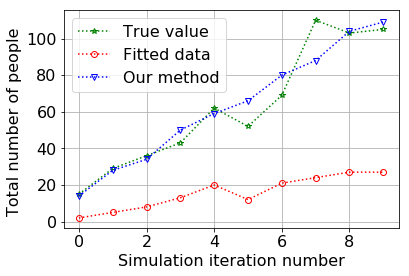

In [110]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

plt.rcParams.update({'font.size': 16})

x_total = lists_cell_static_corner[4]
y_total = lists_cell_static_corner[5]
z_total = lists_cell_static_corner[6]
plot_sim(x_total, y_total, z_total)

In [65]:
def plot_sim_all(x_total, y_total, z1_total, z2_total, z3_total):
    plt.plot(x_total,  linestyle = ":", marker = '*', fillstyle = "none", color = "green", label = "True value"  )
    plt.plot(y_total,  linestyle = ':', marker = "o", fillstyle = "none", color = "red",  label = "Fitted")
    plt.plot(z1_total,  linestyle = ":", marker = 'v', fillstyle = "none", color = "blue",  label = "Method, memory 2 ")
    plt.plot(z2_total,  linestyle = ":", marker = 'v', fillstyle = "none", color = "purple",  label = "Method, memory 4 ")
    plt.plot(z3_total,  linestyle = ":", marker = 'v', fillstyle = "none", color = "pink",  label = "Method, memory 6 ")
    plt.xlabel('Simulation iteration number')
    plt.ylabel('Total number of people ')
    plt.legend(loc = 2, fontsize  = 14)
    plt.ylim(0,150)
    plt.grid(True)
    axes = plt.gca()
    plt.show()

In [49]:
def plot_sim_all_low(x_total, y_total, z1_total, z2_total):
    plt.plot(x_total,   '*', fillstyle = "none", color = "green", label = "True value"  )
    plt.plot(y_total,  "o", fillstyle = "none", color = "red",  label = "Fitted")
    plt.plot(z1_total,    'v', fillstyle = "none", color = "blue",  label = "Method, memory 0 ")
    plt.plot(z2_total,  'v', fillstyle = "none", color = "purple",  label = "Method, memory 5 ")
    plt.xlabel('Simulation iteration number')
    plt.ylabel('Total number of people ')
    plt.legend(loc = 2, fontsize  = 14)
    plt.grid(True)
    axes = plt.gca()
    plt.show()

In [ ]:
#previously the Density estimation method neets to be run on the json files
filepath_method_output = os.path.join(path_simdata,"output/mem_0_low_dens_size_") # after applying the method, here resides the output of it
lists_sim_low_dens_mem0 = run( 105.0, 68.0, 50,54,30,34, 8,  30, 0, 100, 19)

In [ ]:
#previously the Density estimation method neets to be run on the json files
filepath_method_output = os.path.join(path_simdata,"output/mem_5_low_dens_size_") # after applying the method, here resides the output of it
lists_sim_low_dens_mem5 = run( 105.0, 68.0, 50,54,30,34, 8,  30, 0, 100, 19)

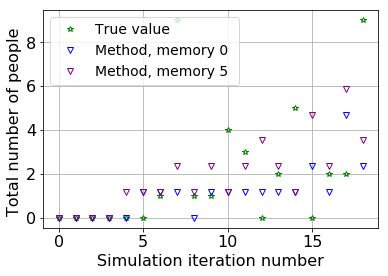

In [50]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

plt.rcParams.update({'font.size': 16})
x_total = lists_sim_low_dens_mem5[4]
y_total = lists_sim_low_dens_mem5[5]
z1_total = lists_sim_low_dens_mem0[6]
z2_total = lists_sim_low_dens_mem5[6]

plot_sim_all_low(x_total, y_total, z1_total, z2_total)

In [309]:
x_total

[0, 0, 0, 0, 0, 0, 1, 9, 1, 1, 4, 3, 0, 2, 5, 0, 2, 2, 9]

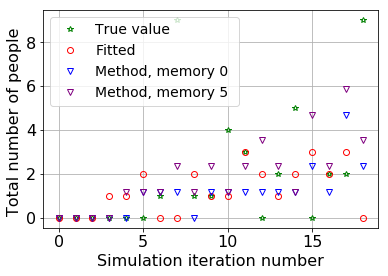

In [112]:
x_total = lists_sim_low_dens_mem5[4]
y_total = lists_sim_low_dens_mem5[5]
z1_total = lists_sim_low_dens_mem0[6]
z2_total = lists_sim_low_dens_mem5[6]

plot_sim_all_low(x_total, y_total, z1_total, z2_total)

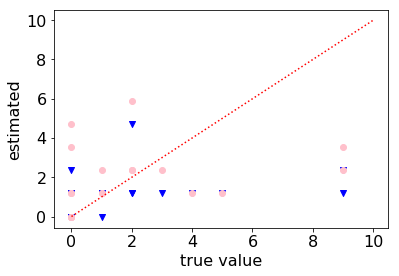

In [52]:
plt.scatter(x_total, z1_total, marker = 'v', color = 'blue')
plt.scatter(x_total, z2_total, color = 'pink')
plt.xlabel('true value')
plt.ylabel('estimated')
plt.plot([0,10], [0,10], linestyle = ':', color = 'red')
plt.show()

In [ ]:
filepath_method_output = os.path.join(path_simdata,"output/size_") # after applying the method, here resides the output of it
lists_sim_mem2 = run( 105.0, 68.0, 50,54,30,34, 8,  30, 0, 6000, 10)

In [ ]:
filepath_method_output = os.path.join(path_simdata,"output/mem_4_size_") # after applying the method, here resides the output of it
lists_sim_mem4 = run( 105.0, 68.0, 50,54,30,34, 8,  30, 0, 6000, 10)

In [ ]:
filepath_method_output = os.path.join(path_simdata,"output/mem_6_size_") # after applying the method, here resides the output of it
lists_sim_mem6 = run( 105.0, 68.0, 50,54,30,34, 8,  30, 0, 6000, 10)

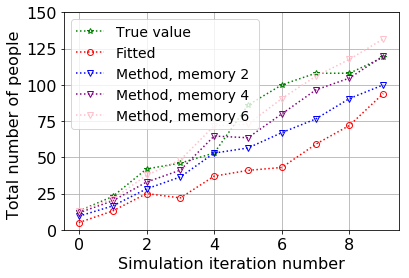

In [66]:
x_total = lists_sim_mem2[4]
y_total = lists_sim_mem2[5]
z1_total = lists_sim_mem2[6]
z2_total = lists_sim_mem4[6]
z3_total = lists_sim_mem6[6]
plot_sim_all(x_total, y_total, z1_total, z2_total, z3_total)

In [ ]:
filepath_method_output = os.path.join(path_simdata,"output/mem_5_size_") # after applying the method, here resides the output of it
lists_sim_mem5 = run( 105.0, 68.0, 50,54,30,34, 8,  30, 0, 2000, 32)

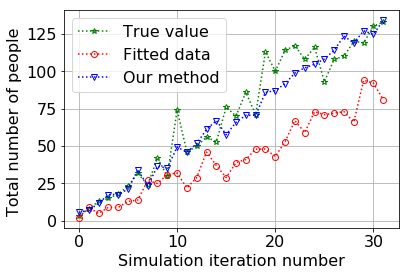

In [70]:
x_total = lists_sim_mem5[4]
y_total = lists_sim_mem5[5]
z_total = lists_sim_mem5[6]
plot_sim(x_total, y_total, z_total)

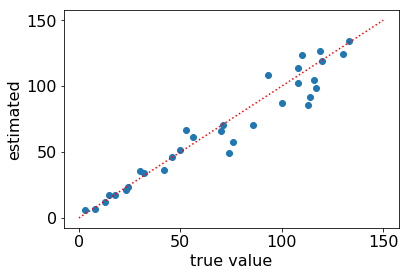

In [84]:
plt.scatter(x_total, z_total)
plt.xlabel('true value')
plt.ylabel('estimated')
plt.plot([0,150], [0,150], linestyle = ':', color = 'red')
plt.show()

In [ ]:
#previously the Density estimation method neets to be run on the json files
path_simdata = "/home/ubuntu/Arena_sim_data/"
path_original_positions = os.path.join(path_simdata, "original_positions_size_") # here are written the original positions (ground truth)
path_fake_positions = os.path.join(path_simdata,"fake_positions_size_") # here come the simulated positions after introducing uncertainties
filepath_method_output = os.path.join(path_simdata,"output/long_size_") # after applying the method, here resides the output of it
lists_sim_long= run_long( 105.0, 68.0, 50,54,30,34, 89,  30,30000, 25)

In [115]:
def plot_sim(x_total, y_total, z_total):
    plt.plot(x_total,  linestyle = ":", marker = '*', fillstyle = "none", color = "green", label = "True value"  )
    plt.plot(y_total,  linestyle = ':', marker = "o", fillstyle = "none", color = "red",  label = "Fitted data")
    plt.plot(z_total,  linestyle = ":", marker = 'v', fillstyle = "none", color = "blue",  label = "Our method")

    plt.xlabel('Time frame')
    plt.ylabel('Total number of people ')
    plt.legend( fontsize  = 14)
    plt.grid(True)
    plt.ylim(0,80)
    axes = plt.gca()
    plt.show()

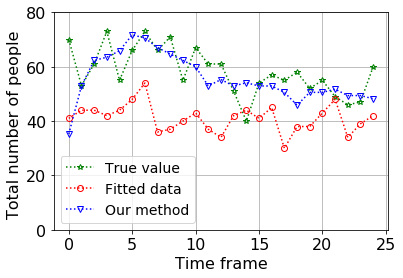

In [116]:
x_total = lists_sim_long[4]
y_total = lists_sim_long[5]
z_total = lists_sim_long[6]
plot_sim(x_total, y_total, z_total)

### Fingerprinting : Analysis on Jaume dataset

In [ ]:
# makes a json file out of given positions
def make_fingerprint_data(positions):
    json = {}
    timestamp = 0   
    fing_positions = []
    for record in positions: #record = [timestamp, personId, x, y]          
        fing_record = make_new_record(record, [record[2], record[3]], 0)
        fing_record["value"]["averagecoordinate"]["error"]["coordinates"] = [0.01, 0.01, 1000.0]#bogus errors as placeholders since there are no gaussian errors in this dataset
        fing_positions.append(fing_record)                               
    return fing_positions            

#### Creating the json files for input to the density estimation method

Before running this the data needs to be created with the fingerprinting notebook

In [43]:
import os
path_fingdata = "/home/ubuntu/ArenaData/Fingerprinting/"

In [ ]:
positions = read_original_positions(os.path.join(path_fingdata,"positions.pkl"))
data = make_fingerprint_data(positions) 
write_fake_positions(data, os.path.join(path_fingdata, "fingerprints_GPS.json"))

In [ ]:
positions

In [ ]:
positions = read_original_positions(os.path.join(path_fingdata,"positions_fitted.pkl"))
data = make_fingerprint_data(positions) 
write_fake_positions(data, os.path.join(path_fingdata, "fingerprints_fitted.json"))

#### Comparing the results

Before running the following analysis the density estimation method has to be applied to the json files

In [44]:
import numpy as np
import os
init_timestamp = 1369908924*1000 + 1804000*1000
measurement_delay = 1000 # in ms
path_original_positions = path_fingdata
path_fake_positions = path_fingdata
filepath_output = os.path.join(path_simdata, "output/fingerprinted_method_")

In [45]:
def get_crowd_count_in_square_fing(timestamp, positions, x_min, x_max, y_min, y_max, belt, interval):
    snapshot = get_a_snapshot(positions,  timestamp, interval)
    crowd_count = 0
    for record in snapshot:
        if record[2] > x_min and record[2] < x_max:
            if record[3] > y_min and record[3] < y_max:
                crowd_count +=1
    return crowd_count

In [46]:
#not used
def get_crowd_count_in_square_fing_new(timestamp, positions, x_min, x_max, y_min, y_max, belt, interval):
    counted = {}
    crowd_count = 0
    for record in positions:
        if record[1] not in counted:
            if record[2] > x_min and record[2] < x_max:
                if record[3] > y_min and record[3] < y_max:
                    if record[0] >= timestamp and record[0] <= timestamp + interval*1000:
                        crowd_count +=1
                        counted[record[1]] = True                    
    return crowd_count

In [47]:
def run_fing( width_stadium, length_stadium,  st_window, end_window, stride):    
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    positions = read_original_positions(path_original_positions + "positions.pkl")    
    fake_positions = read_fake_positions(path_fake_positions  + "fingerprints_fitted.json")
    for window in range (st_window, end_window):
        print(window)
        original_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, positions, x_min, x_max, y_min, y_max, belt, 40) 
        fake_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, fake_positions, x_min, x_max, y_min, y_max, belt, 40)        
        method_crowd_count = get_all_cells(filepath_output, xmin_cell, xmax_cell, ymin_cell, ymax_cell, window)      
        original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [0,0,0,0,original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists  

In [61]:
labels = ["", "","","","True value by GPS", "Fitted data", "Our method"]

The bounding box and time frame values come from the FingerprintedDataAnalysis notebook

In [49]:
x_min = 215
x_max = 310
y_min =  76
y_max = 110
belt = 35
cellsize = 1
xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize

In [ ]:
lists_upper1 = run_fing( 350, 140, 0, 432,30)

In [51]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

In [59]:
def plotScatter(lists, labels):
    fig, ax = plt.subplots()
    ax.scatter(lists[0], lists[1],   marker = 'v',  color = "red", alpha = 0.5, label = "fitted"  )
    ax.scatter(lists[0], lists[2],  marker = "x", color = "blue", alpha = 0.5,  label = "method")
    ax.plot([0,9],[0,9], linestyle = ":", color='green')
    plt.legend(loc = 2, fontsize  = 14)
    plt.ylabel('Number of phones detected')
    plt.xlabel('GPS')
    
    fit = np.polyfit(lists[0], lists[1], deg = 1)
    #ax.plot(x, fit[0] * x + fit[1], color='red')
    met = np.polyfit(lists[0], lists[2], deg = 1)
    #ax.plot(x, met[0] * x + met[1], color='blue')
    plt.gca().set_aspect('equal')
    fig_size = plt.rcParams["figure.figsize"] 
    # Set figure width to 12 and height to 9
    #fig_size[0] = 6
    #fig_size[1] = 4
    #plt.rcParams["figure.figsize"] = fig_size
    #plt.rcParams["figure.dpi"] = 300
    plt.show()

In [66]:
def plotLists(lists, labels):
    x =lists[0]
    y= lists[1]
    z =lists[2]
    plt.plot(x, '*', fillstyle="none", color = "green", alpha = 0.8, label = labels[0]  )
    #plt.plot(y,  ':', color = "red", alpha = 0.8,  label = labels[1])
    plt.plot(z,  alpha = 0.6, color = "blue", label = labels[2])        
    plt.legend(loc = 2, fontsize  = 14)
    plt.ylabel('Number of phones detected')
    plt.xlabel('Time frame number')
    plt.ylim(0,12)
    plt.xlim( 215, 415)    
   
    fig_size = plt.rcParams["figure.figsize"] 
    # Set figure width to 12 and height to 9
    #fig_size[0] = 12
    #fig_size[1] = 9
    #plt.rcParams["figure.figsize"] = fig_size
    #plt.rcParams["figure.dpi"] = 300
    plt.show()

40s window, 30s step:

In [ ]:
#memory 0, window 40 sec, stride 30 sec:

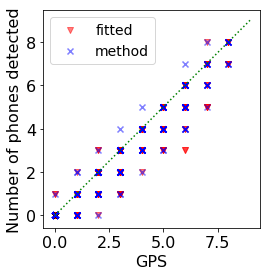

In [60]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np

plotScatter(lists_upper1[4:], labels[4:])

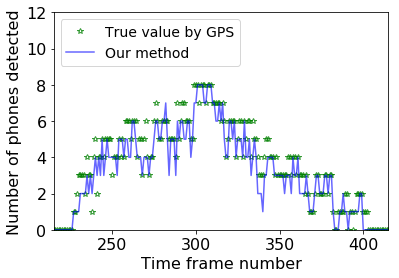

In [67]:
plotLists(lists_upper1[4:], labels[4:])

In [ ]:
plotLists(lists_upper1[4:], labels[4:])

In [ ]:
x_min = 215
x_max = 310
y_min =  20
y_max = 50
belt = 35
cellsize = 1
xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize

In [ ]:
lists_down = run_fing(350, 140, 0, 432, 30)

In [ ]:
def plotLists2(lists, labels):
    plt.plot(lists[0], '*', fillstyle="none", color = "green", alpha = 0.8, label = labels[0]  )
    plt.plot(lists[1],  ':', color = "red", alpha = 0.8,  label = labels[1])
    plt.plot(lists[2],  alpha = 0.6, color = "blue", label = labels[2])
    plt.legend(loc=2)
    plt.ylabel('Number of phones in the lower box')
    #plt.ylim(0,9)
    plt.xlim(0, 350)
    plt.show()

In [ ]:
plotLists2(lists_down[4:], labels[4:])

In [ ]:
from operator import add
total_lists = []         
for i in range(0,3):
    total_list = list(map (add, lists_down[4:][i] , lists_upper1[4:][i]))
    total_lists.append(total_list)
plotLists(total_lists, labels[4:])

## Arena Sensation data: comparison of results

In [73]:
import numpy as np
init_timestamp = 1436067069000 - 5*60*1000
#path_original_positions = "F:/ArenaData/Fingerprinting/"
path_fake_positions = "/home/ubuntu/ArenaData/arena_fits/"

In [74]:
fake_positions = read_fake_positions(path_fake_positions  + "2015-07-05.json")

In [75]:
#previously the Density estimation method neets to be run on the json files
filepath_method_output = os.path.join(path_simdata,"output/WiFi_long") # after applying the method, here resides the output of it


In [76]:
def get_crowd_count_in_square_arena(timestamp, positions, x_min, x_max, y_min, y_max, belt, interval):
    snapshot = get_a_snapshot(positions,  timestamp, interval)
    crowd_count = 0
    for record in snapshot:
        if record[2] > x_min and record[2] < x_max:
            if record[3] > y_min and record[3] < y_max:
                crowd_count +=1
    return crowd_count

def get_crowd_count_in_triangle_arena(timestamp, positions, x_min, x_max, y_min, y_max, belt, interval):
    snapshot = get_a_snapshot(positions,  timestamp, interval)
    crowd_count = 0
    a = (y_max-y_min)/(x_min-x_max)
    b = y_max - a*x_min
    for record in snapshot:
        if record[2] > x_min and record[2] < x_max:
            if record[3] > y_min and record[3] < y_max:
                if record[3] < a*record[2] + b:
                    crowd_count +=1
    return crowd_count

def get_all_cells_triangle(filepath,  xmin_cell, xmax_cell, ymin_cell, ymax_cell, timeperiod):
    total =0   
    a = (ymax_cell-ymin_cell)/(xmin_cell-xmax_cell)
    b = ymax_cell - a*xmin_cell
    z_data = np.loadtxt(filepath + 'dens_histo_%d.csv' % timeperiod, delimiter=',')
    for cell_x in range (int(xmin_cell), int(xmax_cell)):
        for cell_y in range (int(ymin_cell), int(ymax_cell)):
            if cell_y < a * cell_x + b:
                total += z_data[cell_y][cell_x]
    return round(total)   

In [77]:
def run_Arena( width_stadium, length_stadium,  st_window, end_window, stride):    
    original_crowd_count_list = []
    fake_crowd_count_list = []
    method_crowd_count_list = []
    #positions = read_original_positions(path_original_positions + "positions.pkl")    
    #fake_positions = read_fake_positions(path_fake_positions  + "2015-07-05.json")
    for window in range (st_window, end_window):
        print(window)
        #original_crowd_count = get_crowd_count_in_square_fing(init_timestamp+window*stride*1000, positions, x_min, x_max, y_min, y_max, belt, 60) 
        fake_crowd_count = get_crowd_count_in_triangle_arena(init_timestamp+window*stride*1000, fake_positions, x_min, x_max, y_min, y_max, belt, 40)  
        method_crowd_count = 1.176* get_all_cells_triangle(filepath_method_output, xmin_cell, xmax_cell, ymin_cell, ymax_cell, window)      
        #original_crowd_count_list.append(original_crowd_count)
        fake_crowd_count_list.append(fake_crowd_count)
        method_crowd_count_list.append(method_crowd_count)
        #print("Original crowd count:" + str(original_crowd_count) )
        print("Fake crowd count:" + str(fake_crowd_count) )
        print("Method crowd count:" + str(method_crowd_count) )
    lists = [0,0,0,0,original_crowd_count_list,fake_crowd_count_list, method_crowd_count_list]    
    return lists

In [78]:
x_min = 39
x_max = x_min + 15
y_min =  -39
y_max = y_min + 15
cellsize = 1
xmin_cell, xmax_cell, ymin_cell, ymax_cell = x_min/cellsize, x_max/cellsize, y_min/cellsize, y_max/cellsize

In [79]:
stride = 30

In [ ]:
belt = 30#not used

lists_cell15= run_Arena( 240, 180, 0, 40 ,stride)

In [ ]:
init_timestamp = 1436067069000 - 180*60*1000

belt = 30#not used
lists_cell15= run_Arena( 240, 180, 0, 60 ,stride)

In [88]:
def plotListsArenalong(lists):
    labels =  ["z","fitted", "method"]
    #plt.plot(lists[0], '*', fillstyle="none", color = "green", alpha = 0.8, label = labels[0]  )
    plt.plot(lists[5],  ':', color = "red", alpha = 0.9,  label = labels[1])
    plt.plot([x for x in lists[6]],  alpha = 0.9, color = "blue", label = labels[2])
    #plt.plot(frames, video, ':', marker = "*", color = "green", label = "video")
    #plt.scatter(frames, video, marker = "*", color = "green")
    plt.legend( fontsize = 16)
    plt.grid(True)
    #fig_size = plt.rcParams["figure.figsize"] 
    ## Set figure width to 12 and height to 9
    #fig_size[0] = 9
    #fig_size[1] = 6
    
    #plt.rcParams["figure.figsize"] = fig_size
    #plt.rcParams["figure.dpi"] = 500
    plt.ylabel('Number of people')
    plt.xlabel('Time frame')
    #plt.ylim(0,9)
    #plt.xlim(20, 115)    
    plt.show()

In [83]:
def plotListsArena(lists, frames, video):
    labels =  ["z","fitted", "method"]
    #plt.plot(lists[0], '*', fillstyle="none", color = "green", alpha = 0.8, label = labels[0]  )
    #plt.plot(lists[5],  ':', color = "red", alpha = 0.9,  label = labels[1])
    plt.plot([x for x in lists[6]],  alpha = 0.9, color = "blue", label = labels[2])
    plt.plot(frames, video, ':', marker = "*", color = "green", label = "video")
    #plt.scatter(frames, video, marker = "*", color = "green")
    plt.legend( fontsize = 16)
    plt.grid(True)
    #fig_size = plt.rcParams["figure.figsize"] 
    ## Set figure width to 12 and height to 9
    #fig_size[0] = 9
    #fig_size[1] = 6
    
    #plt.rcParams["figure.figsize"] = fig_size
    #plt.rcParams["figure.dpi"] = 500
    plt.ylabel('Number of people')
    plt.xlabel('Time frame')
    #plt.ylim(0,9)
    #plt.xlim(20, 115)    
    plt.show()

In [240]:
timepoints = [1436067069000,
              1436067124000,
              1436067159000,        
              1436067824000]

In [241]:

frames = [int((timepoints[i] - init_timestamp)/(stride*1000))-1  for i in range(0, len(timepoints))]
video = [44,  51 , 55,  17 ] # those numbers are obtained in the next section ("Get video results")


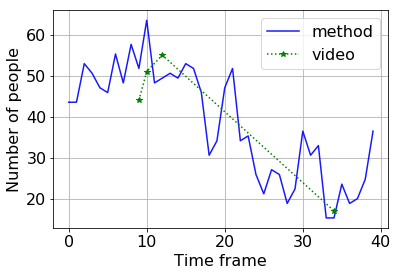

In [149]:
plotListsArena(lists_cell15, frames, video)

In [ ]:
#memory = 3, window = 15, fitted window = 15:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
plotListsArena(lists_cell15, frames, video)

In [ ]:
# memory = 3, window = 15,  fitted window = 60 :

In [ ]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
plotListsArena(lists_cell15, frames, video)

In [ ]:
# memory 0, window = 35:

In [ ]:
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
plotListsArena(lists_cell15, frames, video)

In [ ]:
## the above is obtained with window size 40 memory 0

### Get video results

In [243]:
memory_parameter_set = [0]
interval_parameter_set = [40000] 
binsize_parameter_set = [1,]
stride = 30

bins = binsize_parameter_set[0]

#### movie 1 #############
# 1: 05:31:09
#timepoint = 1436067069000
# 2: 05:32:04 +2:00 UTC
#timepoint = 1436067124000
# 3: 05:32:39
#timepoint = 1436067159000
#### movie 2 #############
# 4: 05:43:44
#timepoint = 1436067824000

timepoints = {1: 1436067069000,
             2: 1436067124000,
             3: 1436067159000, 
             4: 1436067824000}

xsize = 15; ysize = 15
x1= 39
x2 = x1 + xsize
y1 = -39
y2 = y1 + ysize

The comparison code below runs for timeinterval = 40.
The code iterates over the 4 time points. 

In [244]:
video = []
wifi = []

for datapointNr in range(1,len(timepoints) + 1):
    # load the video people count file
    heads = np.loadtxt('headcount-locations-%d-man.csv' % datapointNr, delimiter=',')

    # first swap columns, then mirror y-coordinates in x-axis 
    # to be consistent with wi-fi coordinates
    heads[:,[0, 1]] = heads[:,[1, 0]]
    heads[:,1] = -heads[:,1]

    binsize = xsize / bins
    
    video_estimate = np.zeros((bins, bins))
    a = (y2-y1)/(x1-x2)
    bb = y2 - a*x1
    for b in range(len(heads)):
        if  heads[b][0] >= x1 and heads[b][0] < x2 and heads[b][1] >= y1 and heads[b][1] < y2 and heads[b][1] < a*heads[b][0] + bb :
            x = int((heads[b][0] - x1) / binsize)
            y = int((heads[b][1] - y1) / binsize)           
            video_estimate[y][x] += 1
    video.append(video_estimate)
    for bins in binsize_parameter_set:
        for m in memory_parameter_set:
            for t_int in interval_parameter_set:
                window = int((timepoints[datapointNr] - init_timestamp)/(stride*1000))-1
                wifi_histo = get_all_cells_triangle(filepath_method_output, x1, x2, y1, y2, window)      
    wifi.append(wifi_histo)

# multiply wifi estimate with random/non-random factor
factor = 1.176
wifi = np.array(wifi) * factor

# average densities per m2
#wifi = np.array(wifi) / xsize**2
#video = np.array(video) / ysize**2

Y = np.ravel(video)
X = np.ravel(wifi)

for i in range(len(timepoints)):
    print('Video:', round(Y[i],2),'\t', 'WiFi:', round(X[i],2))

Video: 44.0 	 WiFi: 51.74
Video: 51.0 	 WiFi: 63.5
Video: 55.0 	 WiFi: 49.39
Video: 17.0 	 WiFi: 15.29
